In [1]:
import pickle
import yaml
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

DATASET = "femnist" # change to femnist if you are plotting results on femnist
SAVE_PATH = Path(os.path.abspath("")).parent / "_static"
RESULTS_PATH = Path(os.path.abspath("")).parent / "results"

In [2]:
def saveFig(path, dataset, fig):
    fig.savefig(
        path/f"FedProx_{dataset}.png",
        dpi=None,
        facecolor=fig.get_facecolor(),
        edgecolor="none",
        orientation="portrait",
        format="png",
        transparent=False,
        bbox_inches="tight",
        pad_inches=0.2,
        metadata=None,
    )

In [3]:
# Update the path belows to the multirun directories containing the results for FedProx and FedAvg
def set_path(RESULTS_PATH, dataset):
    path_fedprox_results = RESULTS_PATH / dataset / "FedProx"
    path_fedavg_results = RESULTS_PATH / dataset / "FedAvg"

    return path_fedprox_results, path_fedavg_results

In [4]:
# load all results
def read_pickle_and_config(path_to_pickle):
    with open(path_to_pickle, "rb") as handle:
        data = pickle.load(handle)

    config_path = Path(path_to_pickle).parent / "config.json"
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    return data, config


# loads results.pkl and config of each run
def process_data(path_fedprox_results):
    res_list = []
    for results in list(Path(path_fedprox_results).glob("**/*.pkl")):
        data, config = read_pickle_and_config(results)
        data_cen = data["history"].metrics_centralized
        loss_cen = data["history"].losses_centralized
        stragglers = config["algorithm"]["stragglers_fraction"]
        res_list.append(
            {
                "stragglers": stragglers,
                "mu": config["algorithm"]["mu"],
                "accuracy": np.array([d[1] for d in data_cen["accuracy"]]),
                "loss": np.array([d[1] for d in loss_cen]),
            }
        )

    # to DataFrame
    df = pd.DataFrame.from_dict(res_list)
    # Grouping the DataFrame by 'mu' and 'stragglers' columns
    grouped_df = df.groupby(["mu", "stragglers"])

    # Calculating the mean and standard deviation of 'accuracy' and 'loss' columns
    mean_df = grouped_df[["accuracy", "loss"]].mean()
    return mean_df.reset_index()

In [6]:
# Change the dataset as femnist if plotting femnist results
path_fedprox_results, path_fedavg_results = set_path(RESULTS_PATH, dataset=DATASET)

fedprox_df = process_data(path_fedprox_results)
fedavg_df = process_data(path_fedavg_results)

/Users/ashleyau/Documents/PhD/flwr_pr/flower/baselines/fedprox/fedprox/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-16 12:28:43,062	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [7]:
# let's add a new column to each dataframe that we'll use as label
fedprox_df["strategy"] = "FedProx"
fedavg_df["strategy"] = "FedAvg"

# Now let's fuse both datframes
df = pd.concat([fedavg_df, fedprox_df])
df = df.reset_index()
df

,index,mu,stragglers,accuracy,loss,strategy
0,0,0.0,0.0,"[0.09573497719641158, 0.35208740540269634, 0.3...","[0.34835434220150613, 0.2792616158247364, 0.23...",FedAvg
1,1,0.0,0.5,"[0.09948378689921315, 0.27017491104094626, 0.3...","[0.32579624344936586, 0.3411234711043453, 0.28...",FedAvg
2,2,0.0,0.9,"[0.1010574850899614, 0.1688868841778179, 0.241...","[0.3275652002291721, 0.763826259702559, 0.4516...",FedAvg
3,0,0.0,0.0,"[0.09113917706610536, 0.35348067959705315, 0.4...","[0.31315220520740483, 0.35119333214188186, 0.2...",FedProx
4,1,0.0,0.5,"[0.09813561870395429, 0.2942965970029569, 0.36...","[0.3573179405291074, 0.3040470136100354, 0.342...",FedProx
5,2,0.0,0.9,"[0.08670375382148048, 0.24393324312133516, 0.4...","[0.3130544025975768, 0.3949023498608427, 0.252...",FedProx
6,3,2.0,0.0,"[0.09394076078785144, 0.11925524983711724, 0.1...","[0.34514104460604067, 0.484580088833941, 0.321...",FedProx
7,4,2.0,0.5,"[0.0941362201172756, 0.13567383350874557, 0.11...","[0.32375739963527955, 0.34941877218521855, 0.3...",FedProx
8,5,2.0,0.9,"[0.10146845085951987, 0.12091414824838369, 0.2...","[0.30757023565322184, 0.3920283101724992, 0.23...",FedProx


In [8]:
def viz(dataframe):
    fig, axs = plt.subplots(figsize=(18, 12), nrows=2, ncols=3)
    for row_idx, col_label in enumerate(["loss", "accuracy"]):
        for col_idx, strag_ratio in enumerate([0.0, 0.5, 0.9]):
            ax = axs[row_idx, col_idx]
            exp_data = dataframe.loc[(dataframe["stragglers"] == strag_ratio)]
            for _, exp in exp_data.iterrows():
                y = exp[col_label]
                rounds_array = np.array(range(len(y)))
                label = exp["strategy"]
                label = f"{label}($\mu$={exp['mu']})" if label == "FedProx" else label
                ax.plot(rounds_array, y, label=label, linewidth=2.0)

            ax.grid()
            ax.legend(fontsize=14)
            ax.set_xlabel("Round", fontsize=14)
            ax.set_ylabel("Loss" if row_idx == 0 else "Accuracy", fontsize=14)

            ax.tick_params(axis="both", which="major", labelsize=14)
            ax.tick_params(axis="both", which="minor", labelsize=14)

            if row_idx == 0:
                ax.set_title(f"{int(strag_ratio*100)}% Stragglers", fontsize=14)
    return fig

<>:11: DeprecationWarning: invalid escape sequence '\m'


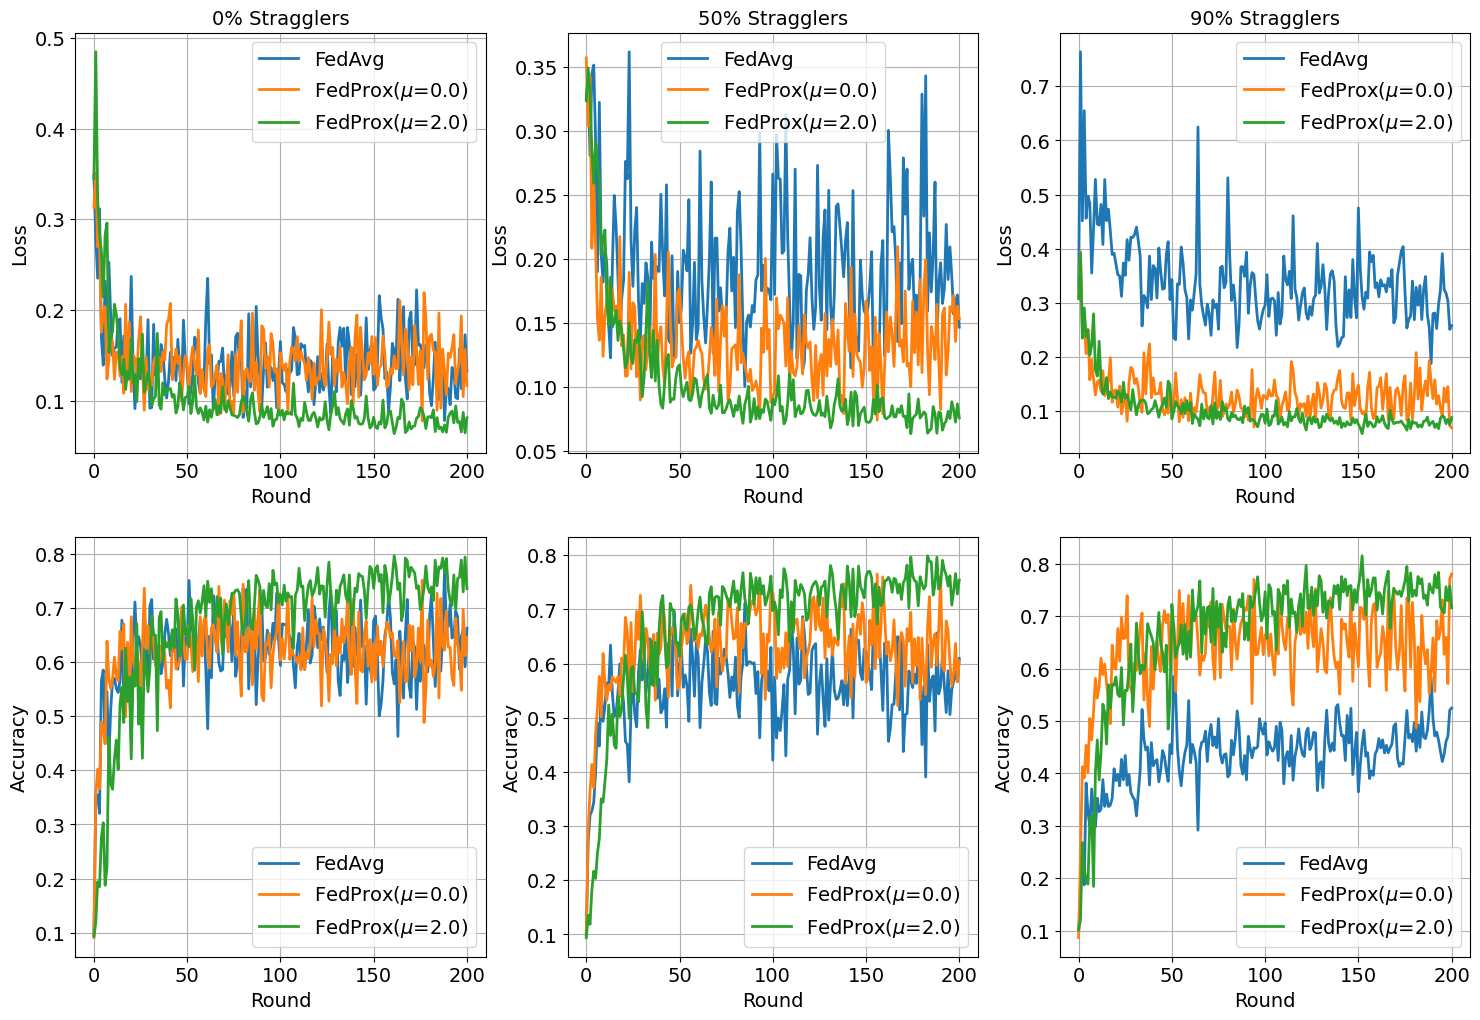

In [9]:
f = viz(df)

In [10]:
# Save path according to your dataset
saveFig(SAVE_PATH, dataset=DATASET, fig=f)